# ResNet-50 for Image Vector Search

ResNet-50 is CNN architecture that belongs to the ResNet (Residual Networks) family, a series of models designed to address the challenges associated with training deep neural networks

![Cat](../assets/cat.jpg)

In [61]:
import os
import uuid

from PIL import Image
import matplotlib.pyplot as plt
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct
import torchvision.models as torch_models
import torchvision.transforms as transforms
import torch
from tqdm import tqdm

In [16]:
client = QdrantClient("http://localhost:6333")

EMBEDDING_DIMENSIONALITY = 2048  # ResNet50 feature vector size
COLLECTION_NAME = "resnet-test"

model = torch_models.resnet50(weights=torch_models.ResNet50_Weights.DEFAULT)
model.eval()

# Remove the final classification layer to get features
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

## Create Qdrant collection with proper configuration

In [17]:
# delete collection
# client.delete_collection(collection_name=COLLECTION_NAME)

In [18]:
client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(
        size=EMBEDDING_DIMENSIONALITY,
        distance=Distance.COSINE
    )
)
print(f"✅ Collection '{COLLECTION_NAME}' created successfully")

✅ Collection 'resnet-test' created successfully


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

preprocess = transforms.Compose([
    transforms.Resize(256),           # ✅ Resize to 256px
    transforms.CenterCrop(224),       # ✅ Center crop to 224x224
    transforms.ToTensor(),            # ✅ Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),  # ✅ ImageNet normalization
])

## Process image

In [41]:
def extract_features(image_path):
    """Extract feature vector from single image"""
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(device)

        # Extract features
        with torch.no_grad():
            features = feature_extractor(input_tensor)
            # Flatten to 1D vector
            features = features.squeeze().cpu().numpy()

        return features.tolist()

    except Exception as e:
        print(f"❌ Error processing {image_path}: {str(e)}")
        return None


image_path = os.path.join(os.path.abspath(""), "..", "assets/cat.jpg")
vector = extract_features(image_path)


len(vector)

2048

## Process folder

Using `pavansanagapati/images-dataset` from kaggle

In [45]:
images_path = os.path.join(os.path.abspath(""), "..", "data")

image_files = []
for subdir, _, files in os.walk(images_path):
    for file in tqdm(files, desc="Loading images"):
        if file.endswith(".jpg") or file.endswith(".png"):
            image_files.append(os.path.join(subdir, file))

print(f"Found {len(image_files)} images.")

Loading images: 100%|██████████| 202/202 [00:00<00:00, 1080675.27it/s]

Found 1018 images.


## Process images in batches

In [48]:
def upload_batch(points):
    """Upload batch of points to Qdrant"""
    try:
        client.upsert(
            collection_name=COLLECTION_NAME,
            points=points
        )
    except Exception as e:
        print(f"❌ Error uploading batch: {str(e)}")

In [49]:
# Process images in batches
batch_size = 32
points = []

for i, image_path in enumerate(tqdm(image_files, desc="Processing images")):
    # Extract features
    features = extract_features(image_path)

    if features is not None:
        # Create point for Qdrant
        point = PointStruct(
            id=str(uuid.uuid4()),  # Unique ID
            vector=features,
            payload={
                "filename": os.path.basename(image_path),
                "full_path": image_path,
                "file_size": os.path.getsize(image_path),
                "index": i
            }
        )
        points.append(point)

        # Upload in batches
        if len(points) >= batch_size:
            upload_batch(points)
            points = []

print(f"✅ Successfully processed {len(image_files)} images")

# Show collection info
try:
    info = client.get_collection(COLLECTION_NAME)
    print(f"\n📊 Collection '{COLLECTION_NAME}' Info:")
    print(f"   • Vectors: {info.points_count}")
    print(f"   • Vector size: {info.config.params.vectors.size}")
    print(f"   • Distance metric: {info.config.params.vectors.distance}")
except Exception as e:
    print(f"❌ Error getting collection info: {str(e)}")


Processing images: 100%|██████████| 1018/1018 [00:38<00:00, 26.70it/s]

✅ Successfully processed 1018 images

📊 Collection 'resnet-test' Info:
   • Vectors: 992
   • Vector size: 2048
   • Distance metric: Cosine


## Search for similar images

In [59]:
query_image_path = os.path.join(os.path.abspath(""), "..", "assets", "magellan.jpg")
query_vector = extract_features(query_image_path)
limit = 5

if query_vector is None:
    print("❌ Could not process query image")


# Search in Qdrant
search_results = client.query_points(
    collection_name=COLLECTION_NAME,
    query=query_vector,
    limit=limit
)

print(f"🔍 Top {limit} similar images to {query_image_path}:")
for i, result in enumerate(search_results.points):
    print(f"   {i+1}. {result.payload['filename']} (similarity: {result.score:.4f})")

print("=" * 7)

🔍 Top 5 similar images to /Users/vasiliy/projects/llm-zoomcamp/02-vector-search/extra/../assets/magellan.jpg:
   1. cat.175.jpg (similarity: 0.6932)
   2. cat.174.jpg (similarity: 0.6858)
   3. cat.160.jpg (similarity: 0.6705)
   4. cat.109.jpg (similarity: 0.6544)
   5. cat.158.jpg (similarity: 0.6457)


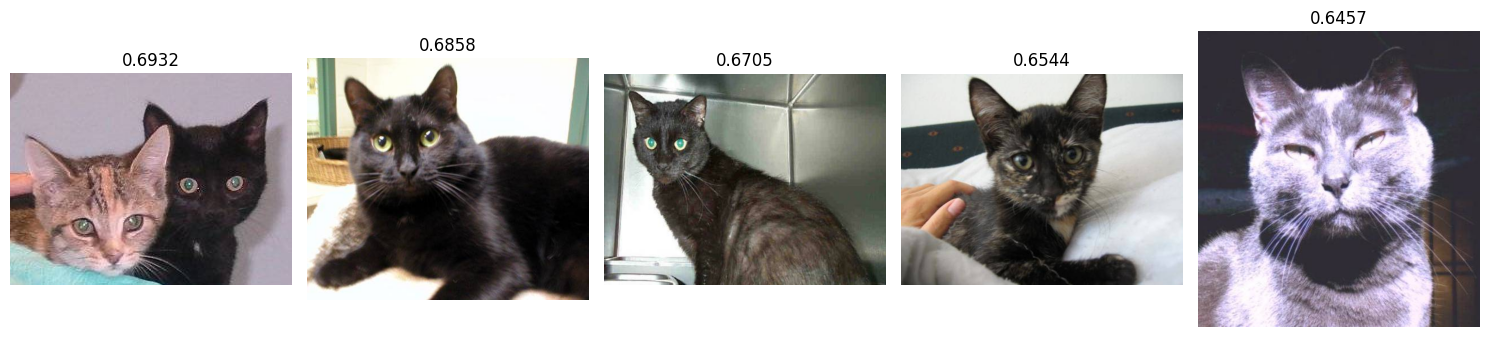

In [70]:
def plot_images_from_path(path, ax, title=None):
    try:
        # Open the image directly from the path
        image = Image.open(path)
        ax.imshow(image)
        ax.axis('off')  # Disable axis
        if title:
            ax.set_title(title)
    except Exception as e:
        print(f"Failed to load image from {path}: {e}")
        ax.imshow(Image.new('RGB', (128, 128), 'gray'))  # Display a gray placeholder if image fails to load
        ax.set_title("Failed to load")
        ax.axis('off')

def plot_random_images(array, rows=1, cols=5):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))
    axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

    for ax, (row) in zip(axes, array):
        plot_images_from_path(os.path.join(row.payload['full_path']), ax, title=f'{row.score:.4f}')

    plt.tight_layout()
    plt.show()

plot_random_images(search_results.points)